# U-net

In [7]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model

def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, 2, strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    # print(s1.shape, s2.shape, s3.shape, s4.shape)
    # print(p1.shape, p2.shape, p3.shape, p4.shape)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="UNET")
    return model

# Metrics

In [8]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K

smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

# Train

In [9]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import numpy as np
import cv2
from glob import glob
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
# from unet import build_unet
# from metrics import dice_loss, dice_coef

""" Global parameters """
H = 256
W = 256

def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def load_dataset(path, split=0.2):
    images = sorted(glob(os.path.join(path, "images", "*.png")))
    masks = sorted(glob(os.path.join(path, "masks", "*.png")))

    split_size = int(len(images) * split)

    train_x, valid_x = train_test_split(images, test_size=split_size, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=split_size, random_state=42)

    train_x, test_x = train_test_split(train_x, test_size=split_size, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=split_size, random_state=42)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    x = x / 255.0
    x = x.astype(np.float32)
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  ## (h, w)
    x = cv2.resize(x, (W, H))   ## (h, w)
    x = x / 255.0               ## (h, w)
    x = x.astype(np.float32)    ## (h, w)
    x = np.expand_dims(x, axis=-1)## (h, w, 1)
    return x

def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([H, W, 3])
    y.set_shape([H, W, 1])
    return x, y

def tf_dataset(X, Y, batch=2):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(10)
    return dataset

if __name__ == "__main__":
    """ Seeding """
    np.random.seed(42)
    tf.random.set_seed(42)

    """ Directory for storing files """
    create_dir("files")

    """ Hyperparameters """
    batch_size = 16
    lr = 1e-4
    num_epochs = 30
    model_path = os.path.join("files", "model.h5")
    csv_path = os.path.join("files", "log.csv")

    """ Dataset """
    dataset_path = "/kaggle/input/brain-tumor-segmentation"  # Adjust this path
    (train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_dataset(dataset_path)

    print(f"Train: {len(train_x)} - {len(train_y)}")
    print(f"Valid: {len(valid_x)} - {len(valid_y)}")
    print(f"Test : {len(test_x)} - {len(test_y)}")

    train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
    valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)

    """ Model """
    model = build_unet((H, W, 3))
    model.compile(loss=dice_loss, optimizer=Adam(lr), metrics=[dice_coef])

    callbacks = [
        ModelCheckpoint(model_path, verbose=1, save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
        CSVLogger(csv_path),
        EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False),
    ]

    model.fit(
        train_dataset,
        epochs=num_epochs,
        validation_data=valid_dataset,
        callbacks=callbacks
    )



Train: 1840 - 1840
Valid: 612 - 612
Test : 612 - 612
Epoch 1/30
115/115 [==============================] - ETA: 0s - loss: 0.8695 - dice_coef: 0.1305
Epoch 1: val_loss improved from inf to 0.96060, saving model to files/model.h5
115/115 [==============================] - 117s 926ms/step - loss: 0.8695 - dice_coef: 0.1305 - val_loss: 0.9606 - val_dice_coef: 0.0393 - lr: 1.0000e-04
Epoch 2/30
115/115 [==============================] - ETA: 0s - loss: 0.7625 - dice_coef: 0.2375
Epoch 2: val_loss did not improve from 0.96060
115/115 [==============================] - 104s 908ms/step - loss: 0.7625 - dice_coef: 0.2375 - val_loss: 0.9771 - val_dice_coef: 0.0229 - lr: 1.0000e-04
Epoch 3/30
115/115 [==============================] - ETA: 0s - loss: 0.6900 - dice_coef: 0.3100
Epoch 3: val_loss did not improve from 0.96060
115/115 [==============================] - 104s 908ms/step - loss: 0.6900 - dice_coef: 0.3100 - val_loss: 0.9705 - val_dice_coef: 0.0298 - lr: 1.0000e-04
Epoch 4/30
115/115 [=

# Test

In [10]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import numpy as np
import cv2
import pandas as pd
from glob import glob
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.utils import CustomObjectScope
from sklearn.metrics import f1_score, jaccard_score, precision_score, recall_score
# from metrics import dice_loss, dice_coef
# from train import load_dataset
# from unet import build_unet

""" Global parameters """
H = 256
W = 256

""" Creating a directory """
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def save_results(image, mask, y_pred, save_image_path):
    mask = np.expand_dims(mask, axis=-1)
    mask = np.concatenate([mask, mask, mask], axis=-1)

    y_pred = np.expand_dims(y_pred, axis=-1)
    y_pred = np.concatenate([y_pred, y_pred, y_pred], axis=-1)
    y_pred = y_pred * 255

    line = np.ones((H, 10, 3)) * 255

    cat_images = np.concatenate([image, line, mask, line, y_pred], axis=1)
    cv2.imwrite(save_image_path, cat_images)


if __name__ == "__main__":
    """ Seeding """
    np.random.seed(42)
    tf.random.set_seed(42)

    """ Directory for storing files """
    create_dir("results")

    """ Load the model """
    with CustomObjectScope({"dice_coef": dice_coef, "dice_loss": dice_loss}):
        model = tf.keras.models.load_model(os.path.join("files", "model.h5"))

    """ Dataset """
    dataset_path = "/kaggle/input/brain-tumor-segmentation"  # Adjust this path
    (train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_dataset(dataset_path)

    """ Prediction and Evaluation """
    SCORE = []
    for x, y in tqdm(zip(test_x, test_y), total=len(test_y)):
        """ Extracting the name """
        name = x.split("/")[-1]

        """ Reading the image """
        image = cv2.imread(x, cv2.IMREAD_COLOR) ## [H, w, 3]
        image = cv2.resize(image, (W, H))       ## [H, w, 3]
        x = image/255.0                         ## [H, w, 3]
        x = np.expand_dims(x, axis=0)           ## [1, H, w, 3]

        """ Reading the mask """
        mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (W, H))

        """ Prediction """
        y_pred = model.predict(x, verbose=0)[0]
        y_pred = np.squeeze(y_pred, axis=-1)
        y_pred = y_pred >= 0.5
        y_pred = y_pred.astype(np.int32)

        """ Saving the prediction """
        save_image_path = os.path.join("results", name)
        save_results(image, mask, y_pred, save_image_path)

        """ Flatten the array """
        mask = mask/255.0
        mask = (mask > 0.5).astype(np.int32).flatten()
        y_pred = y_pred.flatten()

        """ Calculating the metrics values """
        f1_value = f1_score(mask, y_pred, labels=[0, 1], average="binary")
        jac_value = jaccard_score(mask, y_pred, labels=[0, 1], average="binary")
        recall_value = recall_score(mask, y_pred, labels=[0, 1], average="binary", zero_division=0)
        precision_value = precision_score(mask, y_pred, labels=[0, 1], average="binary", zero_division=0)
        SCORE.append([name, f1_value, jac_value, recall_value, precision_value])

    """ Metrics values """
    score = [s[1:]for s in SCORE]
    score = np.mean(score, axis=0)
    print(f"F1: {score[0]:0.5f}")
    print(f"Jaccard: {score[1]:0.5f}")
    print(f"Recall: {score[2]:0.5f}")
    print(f"Precision: {score[3]:0.5f}")

    df = pd.DataFrame(SCORE, columns=["Image", "F1", "Jaccard", "Recall", "Precision"])
    df.to_csv("files/score.csv")


100%|██████████| 612/612 [02:45<00:00,  3.70it/s]

F1: 0.76328
Jaccard: 0.67866
Recall: 0.75817
Precision: 0.82564


# Plotting Train and validation loss

Epoch 1/30
115/115 [==============================] - ETA: 0s - loss: 0.0848 - dice_coef: 0.9152
Epoch 1: val_loss improved from 0.18850 to 0.18772, saving model to files/model.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


115/115 [==============================] - 115s 924ms/step - loss: 0.0848 - dice_coef: 0.9152 - val_loss: 0.1877 - val_dice_coef: 0.8112 - lr: 1.0000e-05
Epoch 2/30
115/115 [==============================] - ETA: 0s - loss: 0.0833 - dice_coef: 0.9167
Epoch 2: val_loss improved from 0.18772 to 0.18721, saving model to files/model.h5
115/115 [==============================] - 106s 918ms/step - loss: 0.0833 - dice_coef: 0.9167 - val_loss: 0.1872 - val_dice_coef: 0.8117 - lr: 1.0000e-05
Epoch 3/30
115/115 [==============================] - ETA: 0s - loss: 0.0818 - dice_coef: 0.9182
Epoch 3: val_loss improved from 0.18721 to 0.18586, saving model to files/model.h5
115/115 [==============================] - 106s 918ms/step - loss: 0.0818 - dice_coef: 0.9182 - val_loss: 0.1859 - val_dice_coef: 0.8130 - lr: 1.0000e-05
Epoch 4/30
115/115 [==============================] - ETA: 0s - loss: 0.0804 - dice_coef: 0.9196
Epoch 4: val_loss improved from 0.18586 to 0.18585, saving model to files/model.h

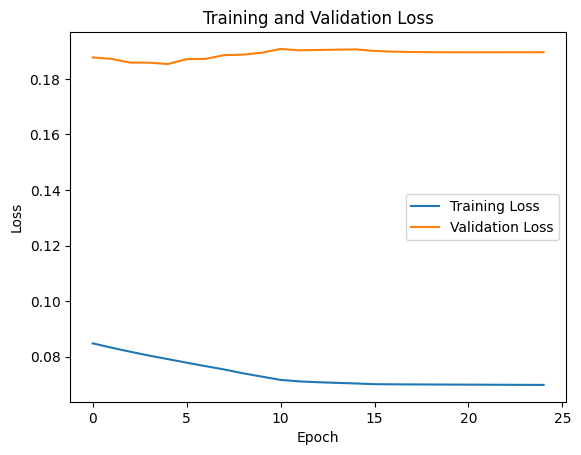

In [11]:
import matplotlib.pyplot as plt

# Train the model and capture the training history
history = model.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=valid_dataset,
    callbacks=callbacks
)

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Showing how our model segments the images

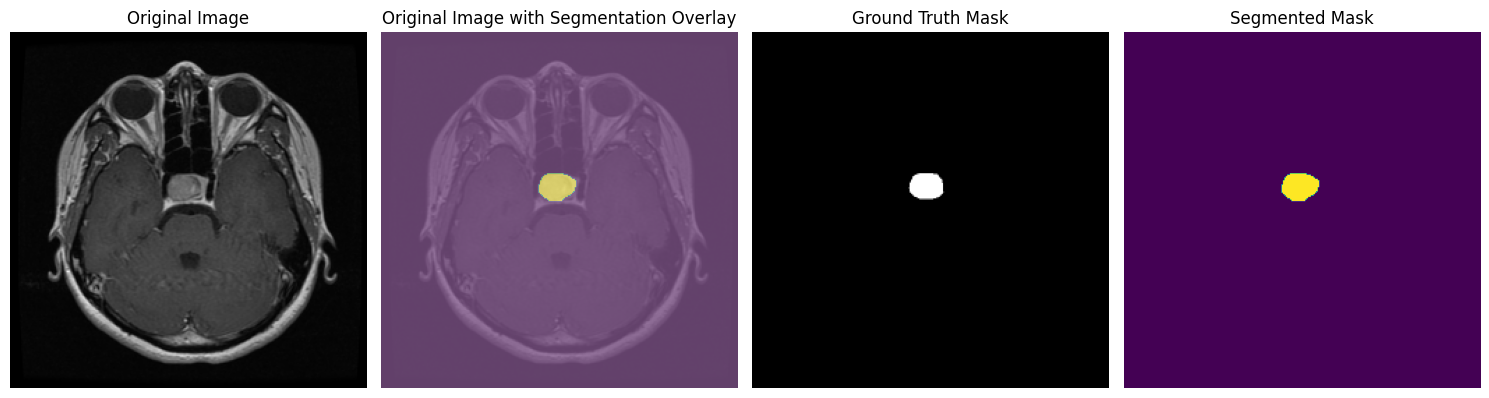

In [26]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import CustomObjectScope

# Define global parameters
H = 256
W = 256

# Function to plot results (original image with transparency, mask, and prediction)
def plot_results(original_image, image, mask, y_pred):
    plt.figure(figsize=(15, 5))

    # Plot original image
    plt.subplot(1, 4, 1)
    plt.imshow(original_image)
    plt.title('Original Image')
    plt.axis('off')

    # Plot original image with transparency
    plt.subplot(1, 4, 2)
    plt.imshow(image, alpha=0.5)  # Set alpha parameter for transparency
    plt.imshow(y_pred, alpha=0.5, cmap='viridis')  # Overlay segmented mask with transparency
    plt.title('Original Image with Segmentation Overlay')
    plt.axis('off')

    # Plot ground truth mask
    plt.subplot(1, 4, 3)
    plt.imshow(mask, cmap='gray')
    plt.title('Ground Truth Mask')
    plt.axis('off')

    # Plot segmented mask
    plt.subplot(1, 4, 4)
    plt.imshow(y_pred, cmap='viridis')
    plt.title('Segmented Mask')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Seeding
    np.random.seed(42)
    tf.random.set_seed(42)

    # Load the model
    with CustomObjectScope({"dice_coef": dice_coef, "dice_loss": dice_loss}):
        model = tf.keras.models.load_model(os.path.join("files", "model.h5"))

    # Load the example image and mask
    original_image_path = "/kaggle/input/brain-tumor-segmentation/images/1000.png"
    mask_path = "/kaggle/input/brain-tumor-segmentation/masks/1000.png"

    # Read the images and mask
    original_image = cv2.imread(original_image_path, cv2.IMREAD_COLOR)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    original_image = cv2.resize(original_image, (W, H))
    image = original_image.copy()  # For overlaying
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (W, H))

    # Preprocess the image
    x = image / 255.0
    x = np.expand_dims(x, axis=0)

    # Predict segmentation
    y_pred = model.predict(x, verbose=0)[0]
    y_pred = np.squeeze(y_pred, axis=-1)
    y_pred = y_pred >= 0.5

    # Plot the results
    plot_results(original_image, image, mask, y_pred)


# Showing the model architecture

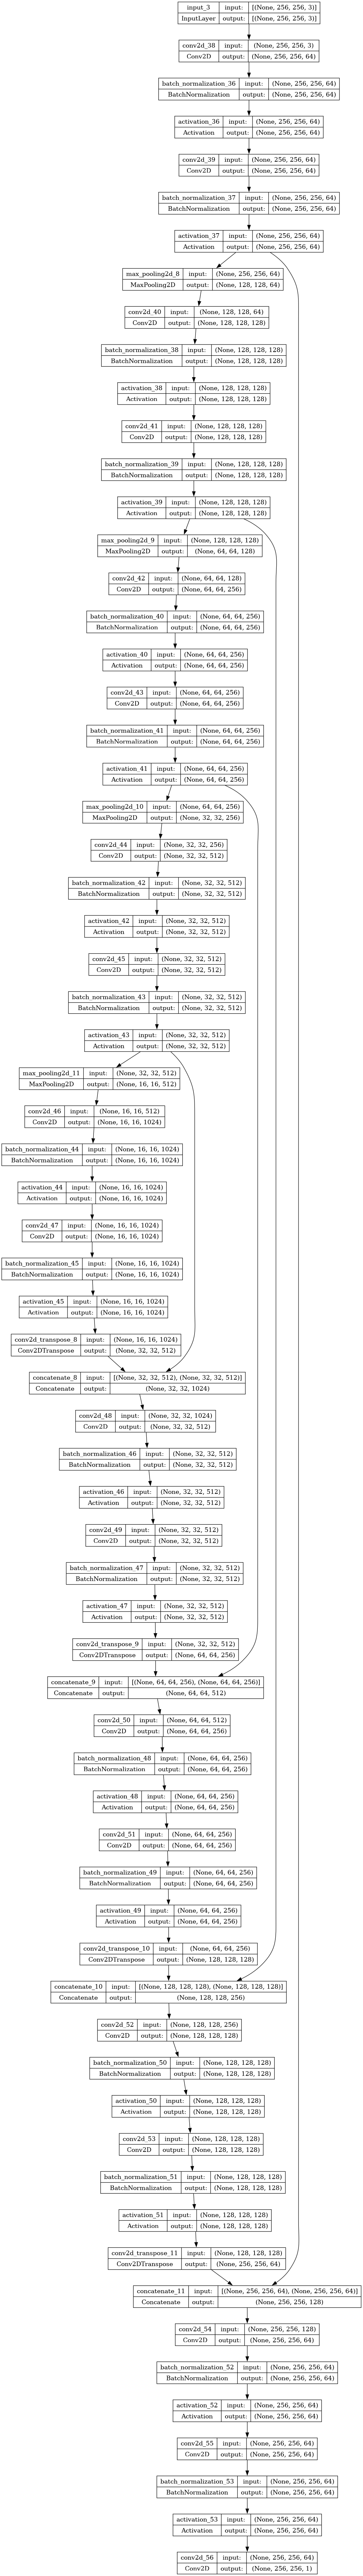

In [14]:
from tensorflow.keras.utils import plot_model

# Plot the model architecture
plot_model(model, to_file='model_architecture.png', show_shapes=True)
